# Modeling for Goodreads Dataset (Part II of II)

This notebook consists of the modeling section for my goodreads project. The model will classify a book on whether it's good or bad.

The initial dataset was sorted by its books' ratings and the top half received the label of 'good' while the bottom half was 'bad.' The ratings were then removed and randomized, and the models were trained on this dataset.

This part 2 of 2 includes:
* [1. Ada Boosting](#ada)
* [2. KNN](#knn)

In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix, roc_auc_score, mean_squared_error, r2_score

In [2]:
#Load relevant datasets
train = pd.read_csv('./data/train_data.csv', index_col=0).reset_index(drop=True)
test = pd.read_csv('./data/test_data.csv', index_col=0).reset_index(drop=True)

scaled_train = pd.read_csv('./data/scaled_train.csv', index_col=0).reset_index(drop=True)
scaled_test = pd.read_csv('./data/scaled_test.csv', index_col=0).reset_index(drop=True)

In [3]:
X_train = train.drop(columns=['quality'])
X_test = test.drop(columns=['quality'])
y_train = train['quality']
y_test = test['quality']

X_scaled_train = scaled_train.drop(columns=['quality'])
X_scaled_test = scaled_test.drop(columns=['quality'])
y_scaled_train = scaled_train['quality']
y_scaled_test = scaled_test['quality']

## Evaluation Functions <a name='eval'></a>
Creating some functions to better visualize the model's metrics.

In [4]:
def plot_roc(fpr1, tpr1, fpr0, tpr0):
    """Plot the ROC curve."""
    
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve for 1')
    plt.plot(fpr0, tpr0, color='navy', lw=2, label='ROC curve for 0')
    plt.plot([0,1], [0,1], lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.legend()
    plt.show()

In [5]:
def evaluate(model, X_train, X_test, y_train, y_test):
    """Obtain the metrics for evaluation of the model."""
    
    #Fit and predict the model
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    #Calculate metrics
    train_RMSE = mean_squared_error(y_train, train_pred, squared=False)
    train_R2 = r2_score(y_train, train_pred)
    test_RMSE = mean_squared_error(y_test, y_pred, squared=False)
    test_R2 = r2_score(y_test, y_pred)
    
    #Print model name
    print(model)
    
    #Print reports
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    print("\nTrain RMSE: {}\nTest RMSE: {}\nTrain R2 score: {}\nTest R2 score: {}".format(
        train_RMSE, test_RMSE, train_R2, test_R2))
    
    #Get probability estimates for roc curve
    probs = model.predict_proba(X_test)
    y_score1 = probs[:,1]
    y_score0 = probs[:,0]
    
    #Calculate ROC metrics
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_score1)
    fpr0, tpr0, thresholds0 = roc_curve(y_test, y_score0)
    
    #Print AUC
    print("AUC for classifying as good (1): {}\nAUC for classifying as bad (0): {}.".format(
        auc(fpr1, tpr1), auc(fpr0, tpr0)))
    
    plot_roc(fpr1, tpr1, fpr0, tpr0)

## Ada Boosting <a name='ada'></a>

In [11]:
#Create ada boost classifier
ada = AdaBoostClassifier()

#Hyperparameters to tune
params = {'n_estimators':[10, 25, 50, 75, 100, 200, 300, 500],
          'learning_rate': [0.001, 0.001, 0.1, 0.3, 0.5, 0.7, 1, 3, 5],
          'random_state':[42]
}

#Create gridsearhcv
scaledada_cv = GridSearchCV(ada, param_grid=params, cv=5, scoring='roc_auc')

#Fit the model
scaledada_cv.fit(X_scaled_train, y_scaled_train)

#Print the best hyperparameters and score
print(scaledada_cv.best_params_, scaledada_cv.best_score_)

{'learning_rate': 0.3, 'n_estimators': 500, 'random_state': 42} 0.6819266666314915


AdaBoostClassifier(learning_rate=0.3, n_estimators=500, random_state=42)
              precision    recall  f1-score   support

         0.0       0.63      0.66      0.64      5766
         1.0       0.64      0.61      0.62      5759

    accuracy                           0.63     11525
   macro avg       0.63      0.63      0.63     11525
weighted avg       0.63      0.63      0.63     11525

[[3811 1955]
 [2268 3491]]

Train RMSE: 0.5982384613418062
Test RMSE: 0.6053270391243157
Train R2 score: -0.4315571235187181
Test R2 score: -0.46568383787772905
AUC for classifying as good (1): 0.68351709613516
AUC for classifying as bad (0): 0.31648290386484.


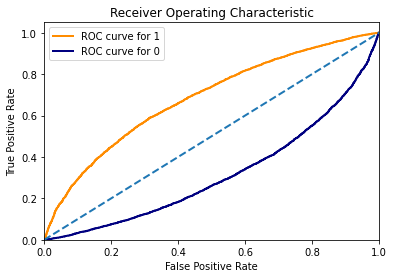

In [13]:
#Run model on best hyperparameters
scaledada_best = AdaBoostClassifier(random_state=42, learning_rate=0.3, n_estimators=500)

#Evaluate model
evaluate(scaledada_best, X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test)

In [12]:
#Create ada boost classifier
ada = AdaBoostClassifier()

#Hyperparameters to tune
params = {'n_estimators':[10, 25, 50, 75, 100, 200, 300, 500],
          'learning_rate': [0.001, 0.001, 0.1, 0.3, 0.5, 0.7, 1, 3, 5],
          'random_state':[42]
}

#Create gridsearhcv
ada_cv = GridSearchCV(ada, param_grid=params, cv=5, scoring='roc_auc')

#Fit the model
ada_cv.fit(X_train, y_train)

#Print the best hyperparameters and score
print(ada_cv.best_params_, ada_cv.best_score_)

{'learning_rate': 0.3, 'n_estimators': 500, 'random_state': 42} 0.6819483518821142


AdaBoostClassifier(learning_rate=0.3, n_estimators=500, random_state=42)
              precision    recall  f1-score   support

         0.0       0.63      0.66      0.64      5766
         1.0       0.64      0.61      0.62      5759

    accuracy                           0.63     11525
   macro avg       0.63      0.63      0.63     11525
weighted avg       0.63      0.63      0.63     11525

[[3811 1955]
 [2268 3491]]

Train RMSE: 0.5982384613418062
Test RMSE: 0.6053270391243157
Train R2 score: -0.4315571235187181
Test R2 score: -0.46568383787772905
AUC for classifying as good (1): 0.68351709613516
AUC for classifying as bad (0): 0.31648290386484.


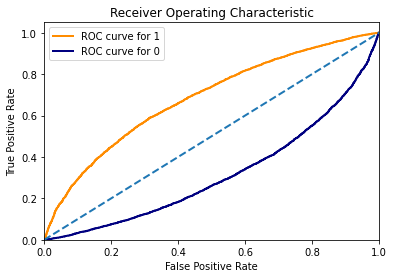

In [14]:
#Run model on best hyperparameters
ada_best = AdaBoostClassifier(random_state=42, learning_rate=0.3, n_estimators=500)

#Evaluate model
evaluate(ada_best, X_train, X_test, y_train, y_test)

## KNN <a name='knn'></a>

In [7]:
#Create KNN classifier
knn = KNeighborsClassifier()

#Hyperparameters to tune
params = {'n_neighbors':[3, 5, 10, 15, 20, 30, 50, 100], 
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto'],
          'leaf_size':[10, 20, 30, 50, 75, 100],
          'p': [1, 2]
}

#Create gridsearchcv
knn_cv = RandomizedSearchCV(knn, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model
knn_cv.fit(X_scaled_train, y_scaled_train)

#Print best hyperparameters and score
print(knn_cv.best_params_, knn_cv.best_score_)

{'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 20, 'algorithm': 'auto'} 0.6258665155450572


KNeighborsClassifier(leaf_size=20, n_neighbors=30, p=1, weights='distance')
              precision    recall  f1-score   support

         0.0       0.58      0.61      0.60      5766
         1.0       0.59      0.56      0.57      5759

    accuracy                           0.59     11525
   macro avg       0.59      0.59      0.59     11525
weighted avg       0.59      0.59      0.59     11525

[[3535 2231]
 [2538 3221]]

Train RMSE: 0.0
Test RMSE: 0.6432698465221928
Train R2 score: 1.0
Test R2 score: -0.6551849923842978
AUC for classifying as good (1): 0.622297771929105
AUC for classifying as bad (0): 0.37770222807089504.


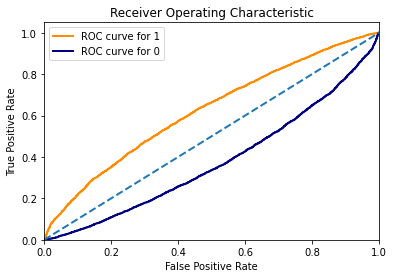

In [9]:
#Run model on best hyperparameters
knn_rbest = KNeighborsClassifier(weights='distance', p=1, n_neighbors=30, leaf_size=20)

#Evaluate model
evaluate(knn_rbest, X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test)

In [ ]:
#Create KNN classifier
knn = KNeighborsClassifier()

#Hyperparameters to tune
params = {'n_neighbors':[3, 5, 10, 15, 20, 30, 50, 100], 
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto'],
          'leaf_size':[10, 20, 30, 50, 75, 100],
          'p': [1, 2]
}

#Create gridsearchcv
knn_cv = RandomizedSearchCV(knn, param_distributions=params, cv=5, scoring='roc_auc')

#Fit model
knn_cv.fit(X_scaled_train, y_scaled_train)

#Print best hyperparameters and score
print(knn_cv.best_params_, knn_cv.best_score_)